In [41]:
import numpy as np 
import pandas as pd 
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline


In [42]:
import os
import sys
project_dir = os.getcwd().split('notebooks')[0]
sys.path.append(project_dir)

In [43]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split 
from src.utils.extract_data import *
from src.utils.metrics_plot import *
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from statistics import mean


In [44]:
df=pd.read_csv(os.path.join(project_dir,'dataset.csv'))
X,Y=extract_values_array(df,p=1,audio=True,usage=True)
l=list(df.columns[0:22])
l.remove('song_index')

In [45]:
metrics=['Accuracy','Precision micro', 'Recall micro', 'F1 score micro', 'Hamming-Loss']
final_res=pd.DataFrame(columns=metrics)

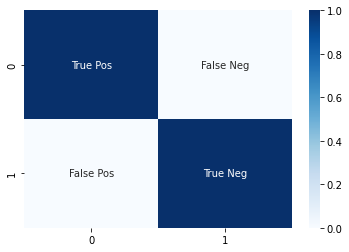

In [46]:
labels = ["True Pos","False Neg","False Pos","True Neg"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(np.eye(2), annot=labels, fmt="", cmap='Blues')
plt.savefig('Modèle Matrice de Confusion')

In [47]:
metrics=['Accuracy','Precision micro', 'Recall micro', 'F1 score micro', 'Hamming-Loss']
final_res=pd.DataFrame(columns=metrics)

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [49]:
X_train, X_test, y_train,y_test = train_test_split(X, Y, train_size=0.7, random_state=88)

In [50]:
i=0
df_hat=pd.DataFrame()
df_test=pd.DataFrame()
auc_labels=[]
params = {
        'eta': 0.3,
        'objective': 'binary:logistic',
        'gamma': 0.01,
        'max_depth': 8,
    }
for label in l:
    Y_train,Y_test = y_train[:,i],y_test[:,i]
    xgtrain = xgb.DMatrix(X_train, Y_train)
    xgtest = xgb.DMatrix(X_test)
    filename =os.path.join(project_dir,'docs/XGB/joblib_XGB2/'+label+'.json')
    if not os.path.exists(filename):
        bst=xgb.train(dtrain=xgtrain,params=params)
        bst.save_model(filename)
    else:
        bst = xgb.Booster()
        bst.load_model(filename)
    y_hat = bst.predict(xgtest)
    df_hat[label] = y_hat
    df_test[label]=Y_test
    title='ROC curve ' + label + ' XGB'
    name_fig=os.path.join(project_dir,'docs/XGB/ROC/'+label)
    AUC= plot_roc_curve(Y_test, y_hat, title=title, name_fig=name_fig,save=True)
    auc_labels.append(AUC)
    i+=1

<Figure size 432x288 with 0 Axes>

In [51]:
y_true=df_test.values
y_pred=(df_hat.values>0.5)
r=all_metrics(y_true,y_pred)
final_res.loc['XGB']=r
final_res

,Accuracy,Precision micro,Recall micro,F1 score micro,Hamming-Loss
XGB,0.749,0.904,0.799,0.849,0.016


##### CM

In [52]:
conf=multilabel_confusion_matrix(y_true,y_pred)
i=0
for cm in conf:
    label=l[i]
    name_fig= os.path.join(project_dir,'docs/LR/CM_LR_audio_only/'+label)
    plot_confusion_matrix(cm,title=label,classes=[label,'Others'],normalize=True,save=True,name_fig=name_fig)
    i=i+1

<Figure size 432x288 with 0 Axes>

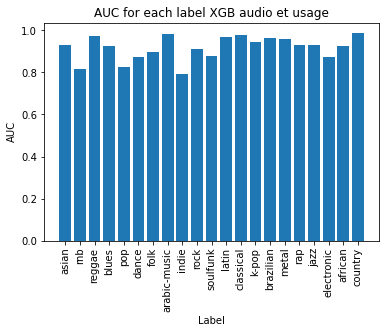

In [53]:
name='../multi-label-classification/ROC_XGB_audio_usage/AUC'
graph_auc(auc_labels,'XGB audio et usage',save=True,name_fig=name)

### TUNNING POUR CLASSIQUE

In [53]:
X_train, X_test, y_train,y_test = train_test_split(X, Y[:,12], train_size=0.8, random_state=88)

In [55]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3,6,10], #par defaut=6, augmente bcp la mémoire et le temps de calcul on se restreint à 10 max
           'learning_rate': [0.01, 0.05, 0.1, 0.3], #taux qu'on met devant chaque nouvel arbre pr la final computation
           'n_estimators': [100, 500, 1000],
          "min_child_weight" : [ 1, 3, 5], #Min child weight makes sure a leaf has enough cover, leading to controlled weight or score. Gamma makes sure we are not splitting a node such that the overall gain from parent to children is very low. So they are not the same.
             "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
           'colsample_bytree': [0.3, 0.7]} # is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
xgbr = XGBClassifier(objective='binary:logistic')
clf = GridSearchCV(estimator=xgbr, param_grid=params,verbose=2)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500; total time=  10.5s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500; total time=  10.1s
[CV] END co

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     r

In [ ]:
print(clf.best_params_)
xgb_hyper=clf.best_estimator

### TUNNING POUR INDIE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y[:,8], train_size=0.8, random_state=88)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3,6,10], #par defaut=6, augmente bcp la mémoire et le temps de calcul on se restreint à 10 max
           'learning_rate': [0.01, 0.05, 0.1, 0.3], #taux qu'on met devant chaque nouvel arbre pr la final computation
           'n_estimators': [100, 500, 1000],
          "min_child_weight" : [ 1, 3, 5], #Min child weight makes sure a leaf has enough cover, leading to controlled weight or score. Gamma makes sure we are not splitting a node such that the overall gain from parent to children is very low. So they are not the same.
             "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
           'colsample_bytree': [0.3, 0.7]} # is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
xgbr = XGBClassifier(objective='binary:logistic')
clf = GridSearchCV(estimator=xgbr, param_grid=params,verbose=4)

In [ ]:
filename =os.path.join(project_dir,'docs/XGB/joblib_XGB/optimized_indie')
xgb = load_fit(clf,X_train,y_train,filename)